<a href="https://colab.research.google.com/github/bhavya-batra/bhavya-batra/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!wget /content/drive/MyDrive/Unet_dataset.zip

/content/drive/MyDrive/Unet_dataset.zip: Scheme missing.


In [2]:
!unzip /content/drive/MyDrive/Unet_dataset.zip

Archive:  /content/drive/MyDrive/Unet_dataset.zip
   creating: Unet_dataset/trainx/
  inflating: Unet_dataset/trainx/X_img_0.bmp  
  inflating: Unet_dataset/trainx/X_img_1.bmp  
  inflating: Unet_dataset/trainx/X_img_10.bmp  
  inflating: Unet_dataset/trainx/X_img_100.bmp  
  inflating: Unet_dataset/trainx/X_img_101.bmp  
  inflating: Unet_dataset/trainx/X_img_102.bmp  
  inflating: Unet_dataset/trainx/X_img_103.bmp  
  inflating: Unet_dataset/trainx/X_img_104.bmp  
  inflating: Unet_dataset/trainx/X_img_105.bmp  
  inflating: Unet_dataset/trainx/X_img_106.bmp  
  inflating: Unet_dataset/trainx/X_img_107.bmp  
  inflating: Unet_dataset/trainx/X_img_108.bmp  
  inflating: Unet_dataset/trainx/X_img_109.bmp  
  inflating: Unet_dataset/trainx/X_img_11.bmp  
  inflating: Unet_dataset/trainx/X_img_110.bmp  
  inflating: Unet_dataset/trainx/X_img_111.bmp  
  inflating: Unet_dataset/trainx/X_img_112.bmp  
  inflating: Unet_dataset/trainx/X_img_113.bmp  
  inflating: Unet_dataset/trainx/X_img_1

In [3]:
from PIL import Image
import os

# specify the directory where the images are stored
image_dir = '/content/Unet_dataset'

# define the subfolders to process
subfolders = ['trainx', 'trainy']

# loop over each subfolder and resize the images
for subfolder in subfolders:
    # get a list of all the image filenames in the subfolder
    subfolder_path = os.path.join(image_dir, subfolder)
    image_filenames = os.listdir(subfolder_path)
    
    # loop over each image filename and resize the image
    for filename in image_filenames:
        # exclude hidden directories and files
        if filename.startswith('.'):
            continue
        
        # open the image using PIL
        image_path = os.path.join(subfolder_path, filename)
        image = Image.open(image_path)
        
        # resize the image
        resized_image = image.resize((224, 224))
        
        # save the resized image
        resized_image.save(image_path)

In [4]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.core import SpatialDropout2D
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

In [5]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [6]:
# X_train = np.array([np.array(Image.open(fname)) for fname in filelist_x])
filelist_x = sorted(glob.glob('/content/Unet_dataset/trainx/*.bmp'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_x])

In [7]:
filelist_y = sorted(glob.glob('/content/Unet_dataset/trainy/*.bmp'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_y])

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 101)

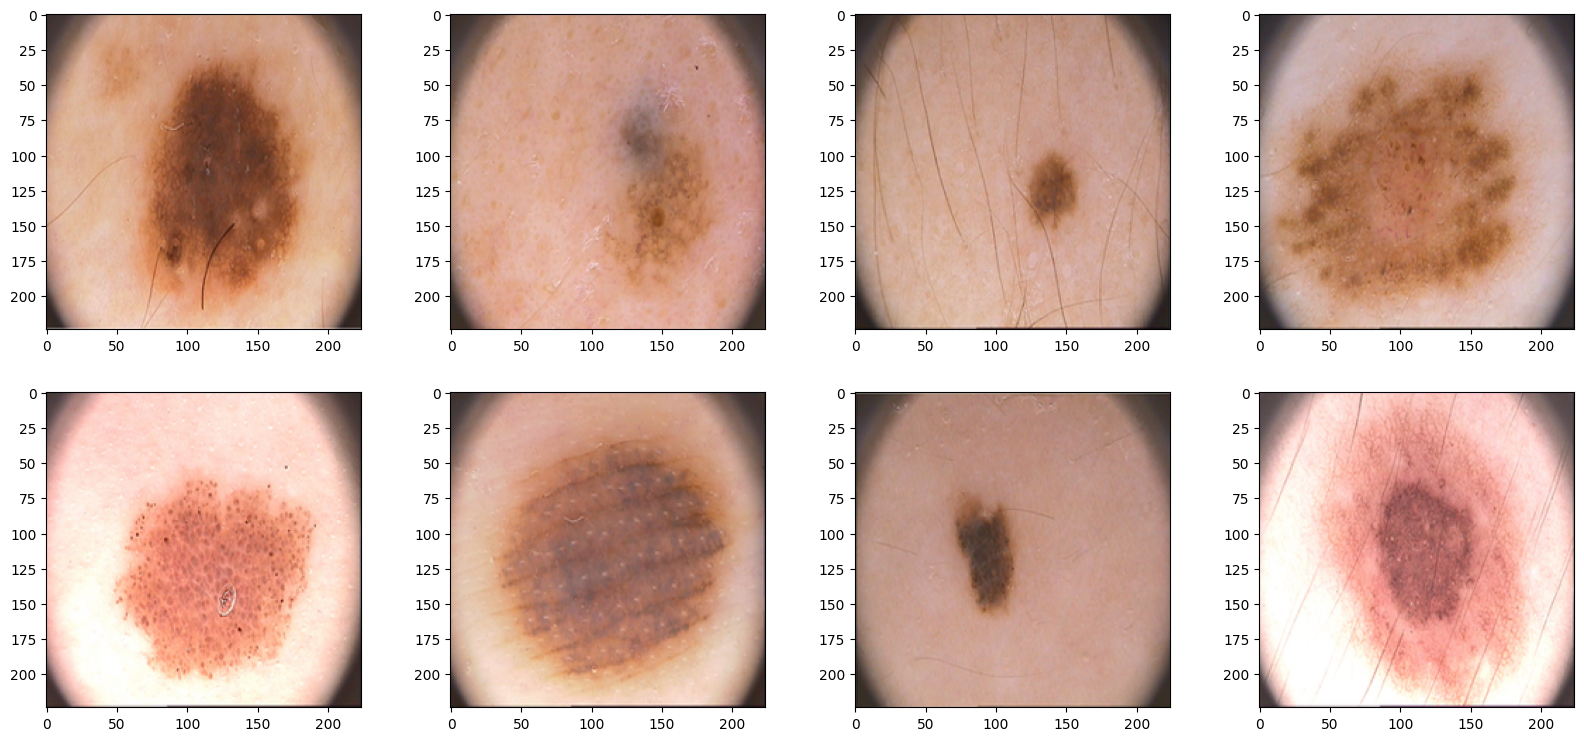

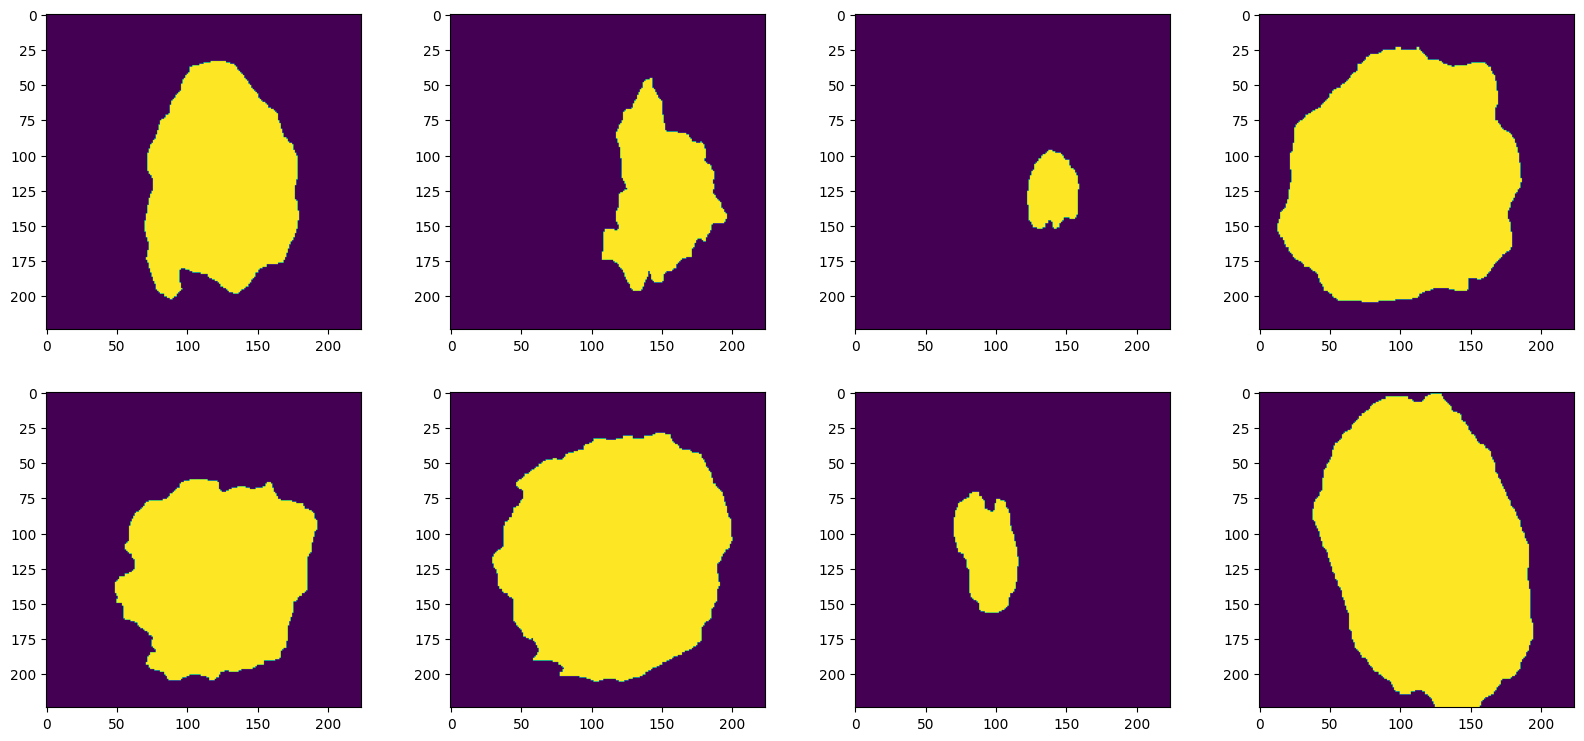

In [9]:
import matplotlib.pyplot as plt

# Plot some images from the X_train dataset
fig1, axs1 = plt.subplots(nrows=2, ncols=4, figsize=(20, 9))

axs1[0, 0].imshow(X_train[0])
axs1[0, 1].imshow(X_train[3])
axs1[0, 2].imshow(X_train[54])
axs1[0, 3].imshow(X_train[77])
axs1[1, 0].imshow(X_train[100])
axs1[1, 1].imshow(X_train[125])
axs1[1, 2].imshow(X_train[130])
axs1[1, 3].imshow(X_train[149])

# Plot some images from the Y_train dataset
fig2, axs2 = plt.subplots(nrows=2, ncols=4, figsize=(20, 9))

axs2[0, 0].imshow(Y_train[0])
axs2[0, 1].imshow(Y_train[3])
axs2[0, 2].imshow(Y_train[54])
axs2[0, 3].imshow(Y_train[77])
axs2[1, 0].imshow(Y_train[100])
axs2[1, 1].imshow(Y_train[125])
axs2[1, 2].imshow(Y_train[130])
axs2[1, 3].imshow(Y_train[149])

plt.show()

In [ ]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [ ]:
# dice coffecient no specific need of it 
# def dice_coe(y_true, y_pred, smooth = 100):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
    precision = true_positives / (predicted_positives + K.epsilon())
    avg_precision = K.mean(precision)
    return avg_precision

In [ ]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [10]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [11]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x, y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x, y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y.astype('float32'))

    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [12]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)
x_rotated_t, y_rotated_t, x_flipped_t, y_flipped_t = img_augmentation(x_test, y_test)

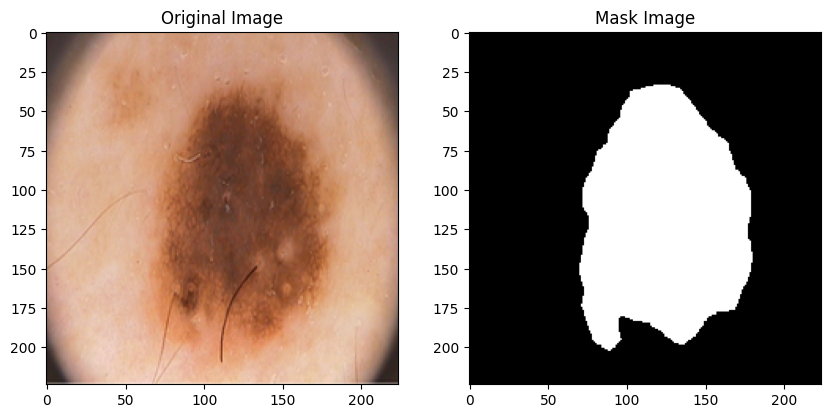

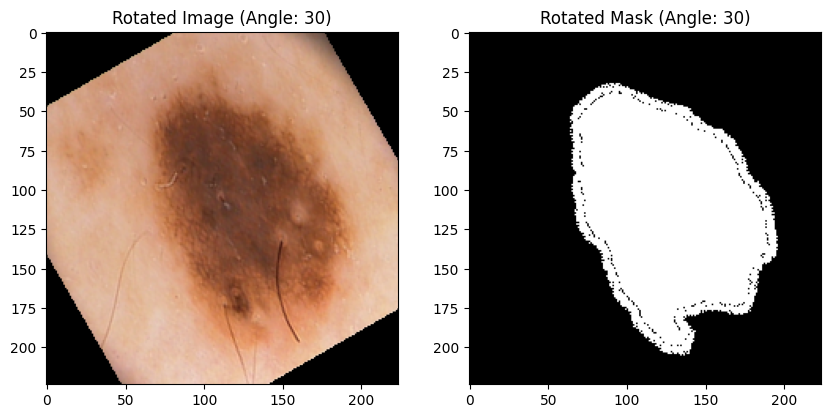

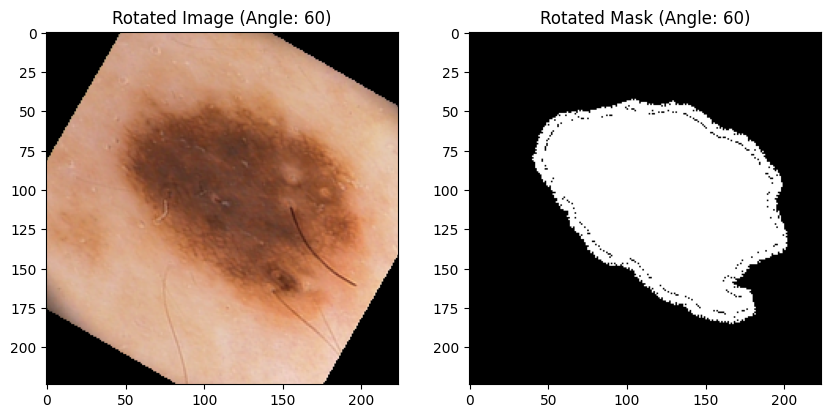

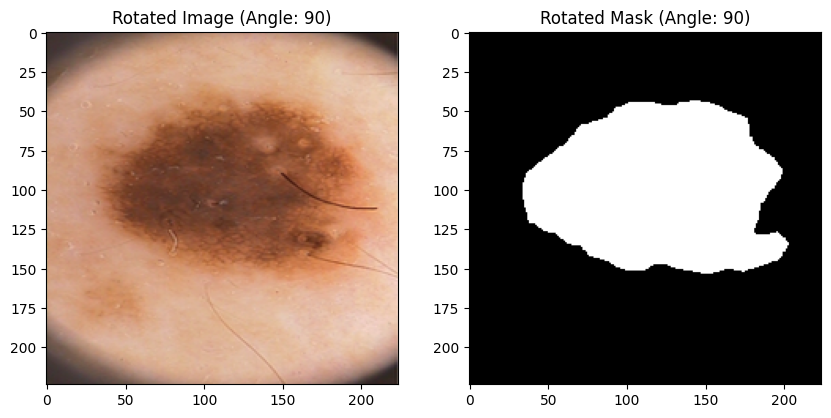

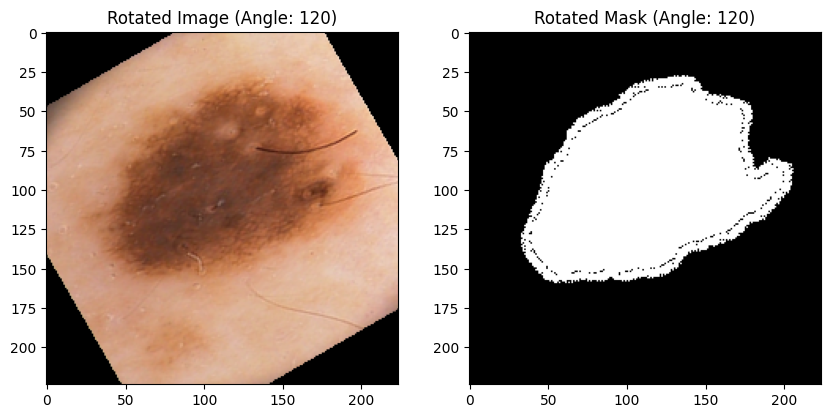

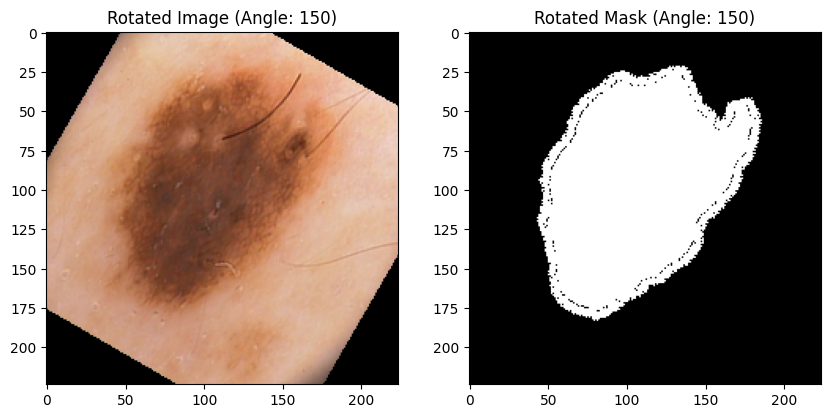

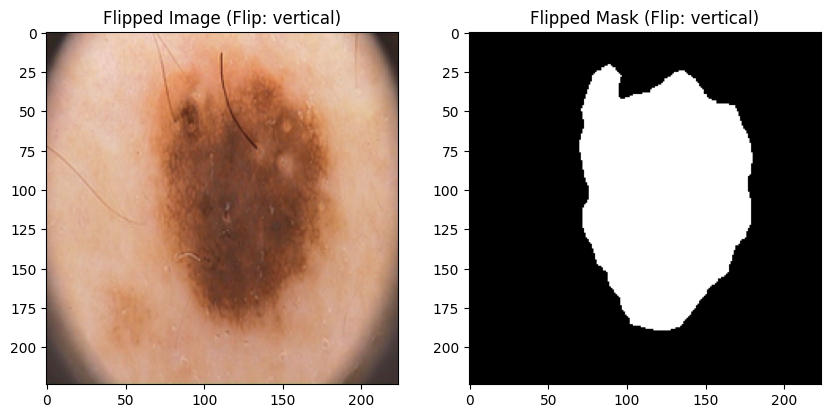

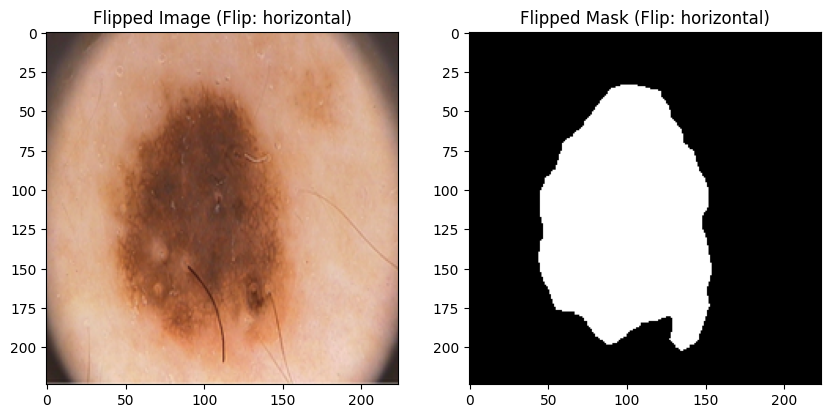

In [13]:
import numpy as np
from scipy import ndimage, misc
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
img_path = '/content/Unet_dataset/trainx/X_img_0.bmp'
img = np.array(Image.open(img_path))

# Load the mask image
mask_path = '/content/Unet_dataset/trainy/Y_img_0.bmp'
mask = np.array(Image.open(mask_path))

# Display the original image and mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Mask Image')
plt.show()

# Define angles for rotation
angles = [30, 60, 90, 120, 150]

# Rotate the image and mask and append to list
rotated_images = []
rotated_masks = []
for angle in angles:
    rotated = ndimage.rotate(img, angle, reshape=False)
    rotated_mask = ndimage.rotate(mask, angle, reshape=False)
    rotated_images.append(rotated)
    rotated_masks.append(rotated_mask)

# Display the rotated images and masks
for i, angle in enumerate(angles):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(rotated_images[i])
    ax[0].set_title('Rotated Image (Angle: {})'.format(angle))
    ax[1].imshow(rotated_masks[i], cmap='gray')
    ax[1].set_title('Rotated Mask (Angle: {})'.format(angle))
    plt.show()

# Flip the image and mask and append to list
flipped_images = []
flipped_masks = []
for axis in [0, 1]:
    flipped = np.flip(img, axis=axis)
    flipped_mask = np.flip(mask, axis=axis)
    flipped_images.append(flipped)
    flipped_masks.append(flipped_mask)

# Display the flipped images and masks
for i, axis in enumerate(['vertical', 'horizontal']):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(flipped_images[i])
    ax[0].set_title('Flipped Image (Flip: {})'.format(axis))
    ax[1].imshow(flipped_masks[i], cmap='gray')
    ax[1].set_title('Flipped Mask (Flip: {})'.format(axis))
    plt.show()

In [14]:
# For training Set
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.2, random_state = 101)

In [16]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))
print("Length of the Augmented Training Set   : {}".format(len(x_train_full)))

Length of the Training Set   : 384
Length of the Test Set       : 40
Length of the Validation Set : 96
Length of the Augmented Training Set   : 480


In [17]:
x_train=tf.cast(x_train, tf.float32)
x_val=tf.cast(x_val, tf.float32)
x_test=tf.cast(x_test, tf.float32)

In [18]:
y_train=tf.cast(y_train, tf.float32)
y_val=tf.cast(y_val, tf.float32)
y_test=tf.cast(y_test, tf.float32)

In [26]:
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation, Dropout, BatchNormalization, Reshape
from keras.models import Model
from keras.optimizers import Adam

# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3

# Define the input shape of the model
input_shape = (224, 224, 3)

# Define the number of output mask channels (1 for binary segmentation)
num_output_channels = 1

def double_conv_layer(x, size, dropout=0.5, batch_norm=True):
    if K.image_data_format() == 'channels_first':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)
    return conv

def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

def dice_coe(y_true, y_pred, smooth=1e-7):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true), -1) + K.sum(K.square(y_pred), -1) + smooth)

def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2])
    union = K.sum(y_true, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2])
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1, 2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)
# def jaccard_distance(y_true, y_pred, smooth=100):
#     intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
#     sum_ = K.sum(K.abs(y_true), axis=[1,2,3]) + K.sum(K.abs(y_pred), axis=[1,2,3])
#     jac = (intersection + smooth) / (sum_ - intersection + smooth)
#     return (1 - jac) * smooth

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def UNET(input_shape, num_output_channels, epochs_num, savename):
    dropout_val=0.50
    if K.image_data_format() == 'th':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, 32)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 64)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 128)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 256)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 512)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    # Bottleneck layer
    conv_7 = double_conv_layer(pool_7, 1024)

    # Upsample path
    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=3)
    up_conv_14 = double_conv_layer(up_14, 512)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=3)
    up_conv_28 = double_conv_layer(up_28, 256)
    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=3)
    up_conv_56 = double_conv_layer(up_56, 128)
    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=3)
    up_conv_112 = double_conv_layer(up_112, 64)
    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=3)
    up_conv_224 = double_conv_layer(up_224, 32)

    conv_final = Conv2D(num_output_channels, (1, 1))(up_conv_224)
    activation_layer = Activation('sigmoid')(conv_final)

    model = Model(inputs=inputs, outputs=activation_layer)

    model.compile(optimizer='adam', loss='mse',metrics=[accuracy,dice_coe,iou,jaccard_distance,precision,recall])
    # jaccard_callback = JaccardCallback(x_val, y_val) hist me val k bad , callbacks=[jaccard_callback]
    hist = model.fit(x_train, y_train, epochs=35, batch_size=12, validation_data=(x_val, y_val))
    model.save(savename)
    return model, hist

In [21]:
# Define input shape and number of output channels
input_shape = (224, 224, 3)
num_output_channels = 1

model, hist= UNET(input_shape=(224, 224, 3), num_output_channels=1, epochs_num=1, savename='unet_1_epochs.h5')
# Save the model weights
model.save_weights('my_model.h5')

32/32 [==============================] - 1096s 34s/step - loss: 0.1423 - accuracy: 0.8129 - dice_coe: 0.5326 - iou: 0.4164 - jaccard_distance: 0.4190 - precision: 0.7355 - recall: 0.7567 - val_loss: 0.6803 - val_accuracy: 0.3197 - val_dice_coe: 0.4116 - val_iou: 0.3197 - val_jaccard_distance: 0.3210 - val_precision: 0.3197 - val_recall: 1.0000


In [22]:
dropout_val=0.50
if K.image_data_format() == 'th':
    inputs = Input((INPUT_CHANNELS, 224, 224))
    axis = 1
else:
    inputs = Input((224, 224, INPUT_CHANNELS))
    axis = 3
    filters = 32

conv_224 = double_conv_layer(inputs, 32)
pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

conv_112 = double_conv_layer(pool_112, 64)
pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

conv_56 = double_conv_layer(pool_56, 128)
pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

conv_28 = double_conv_layer(pool_28, 256)
pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

conv_14 = double_conv_layer(pool_14, 512)
pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    # Bottleneck layer
conv_7 = double_conv_layer(pool_7, 1024)

    # Upsample path
up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=3)
up_conv_14 = double_conv_layer(up_14, 512)

up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=3)
up_conv_28 = double_conv_layer(up_28, 256)
up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=3)
up_conv_56 = double_conv_layer(up_56, 128)
up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=3)
up_conv_112 = double_conv_layer(up_112, 64)
up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=3)
up_conv_224 = double_conv_layer(up_224, 32)

conv_final = Conv2D(num_output_channels, (1, 1))(up_conv_224)
activation_layer = Activation('sigmoid')(conv_final)



In [23]:
model_0 = Model(inputs=inputs, outputs=activation_layer)
model_0.compile(optimizer='adam', loss='mse', metrics=[accuracy, dice_coe, iou, precision, recall, jaccard_distance])

In [24]:
model_0.load_weights('/content/my_model.h5')

In [25]:
# Print metrics after the first epoch
print('Metrics after the first epoch:')
print(f"Loss: {hist.history['loss'][0]*100:.2f}")
print(f"Accuracy: {hist.history['accuracy'][0]*100:.2f}")

Metrics after the first epoch:
Loss: 14.23
Accuracy: 81.29


In [27]:
model, hist= UNET(input_shape=(224, 224, 3), num_output_channels=1,epochs_num=35, savename='unet_40_epochs.h5')

Epoch 1/35
32/32 [==============================] - 1105s 34s/step - loss: 0.1068 - accuracy: 0.8650 - dice_coe: 0.5541 - iou: 0.4895 - jaccard_distance: 0.4924 - precision: 0.8216 - recall: 0.7825 - val_loss: 0.6785 - val_accuracy: 0.3214 - val_dice_coe: 0.4118 - val_iou: 0.3203 - val_jaccard_distance: 0.3216 - val_precision: 0.3202 - val_recall: 1.0000
Epoch 2/35
32/32 [==============================] - 1088s 34s/step - loss: 0.0757 - accuracy: 0.9019 - dice_coe: 0.5847 - iou: 0.5787 - jaccard_distance: 0.5816 - precision: 0.8653 - recall: 0.8320 - val_loss: 0.3663 - val_accuracy: 0.6098 - val_dice_coe: 0.1498 - val_iou: 0.0975 - val_jaccard_distance: 0.1033 - val_precision: 0.2972 - val_recall: 0.1755
Epoch 3/35
32/32 [==============================] - 1085s 34s/step - loss: 0.0727 - accuracy: 0.9064 - dice_coe: 0.5838 - iou: 0.5886 - jaccard_distance: 0.5915 - precision: 0.8782 - recall: 0.8325 - val_loss: 0.1314 - val_accuracy: 0.8366 - val_dice_coe: 0.5021 - val_iou: 0.4913 - val

In [28]:
model_1 = Model(inputs=inputs, outputs=activation_layer)
model_1.compile(optimizer='RMSProp', loss='mae', metrics=[accuracy, dice_coe, iou, precision, recall, jaccard_distance])

In [29]:
model_1.load_weights('/content/unet_40_epochs.h5')

In [30]:
final_accuracy = hist.history['accuracy'][-1] * 100
final_loss = hist.history['loss'][-1] * 100
print("Final Accuracy: {:.2f}%".format(final_accuracy))
print("Final Loss: {:.2f}%".format(final_loss))

Final Accuracy: 95.63%
Final Loss: 3.35%


In [31]:
final_accuracy = hist.history['accuracy'][-1] * 100
final_dice_coe = hist.history['dice_coe'][-1] * 100
final_iou = hist.history['iou'][-1] * 100
final_precision = hist.history['precision'][-1] * 100
final_recall = hist.history['recall'][-1] * 100
final_jaccard_distance = hist.history['jaccard_distance'][-1] * 100

print("Final Accuracy: {:.2f}%".format(final_accuracy))
print("Final Dice Coefficient: {:.2f}%".format(final_dice_coe))
print("Final IOU: {:.2f}%".format(final_iou))
print("Final Precision: {:.2f}%".format(final_precision))
print("Final Recall: {:.2f}%".format(final_recall))
print("Final Jaccard Distance: {:.2f}%".format(final_jaccard_distance))


Final Accuracy: 95.63%
Final Dice Coefficient: 63.55%
Final IOU: 78.86%
Final Precision: 94.07%
Final Recall: 92.50%
Final Jaccard Distance: 79.06%


In [40]:
from tabulate import tabulate

# store the metrics in a list of tuples
metrics = [
    ("Accuracy", "{:.2f}%".format(final_accuracy)),
    ("Dice Coefficient", "{:.2f}%".format(final_dice_coe)),
    ("IOU", "{:.2f}%".format(final_iou)),
    ("Precision", "{:.2f}%".format(final_precision)),
    ("Recall", "{:.2f}%".format(final_recall)),
    ("Jaccard Distance", "{:.2f}%".format(final_jaccard_distance))
]

# print the metrics in a table format
print(tabulate(metrics, headers=["Metric", "Value"]))


Metric            Value
----------------  -------
Accuracy          95.63%
Dice Coefficient  63.55%
IOU               78.86%
Precision         94.07%
Recall            92.50%
Jaccard Distance  79.06%


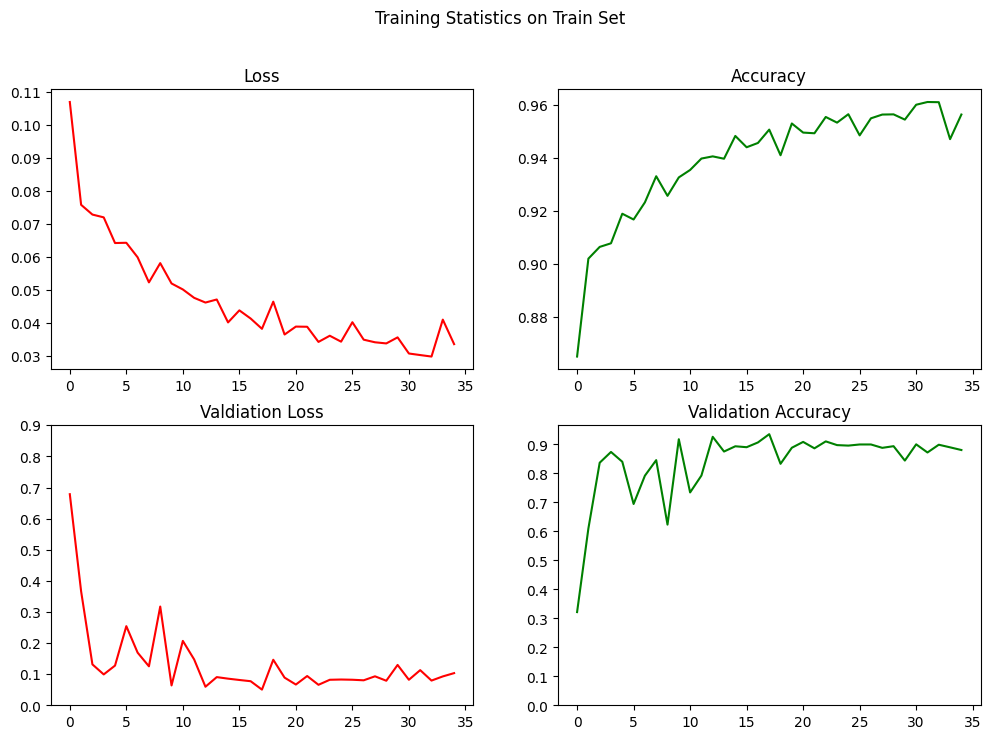

In [32]:
plt.figure(figsize=(12,8))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

1/1 [==============================] - 1s 1s/step


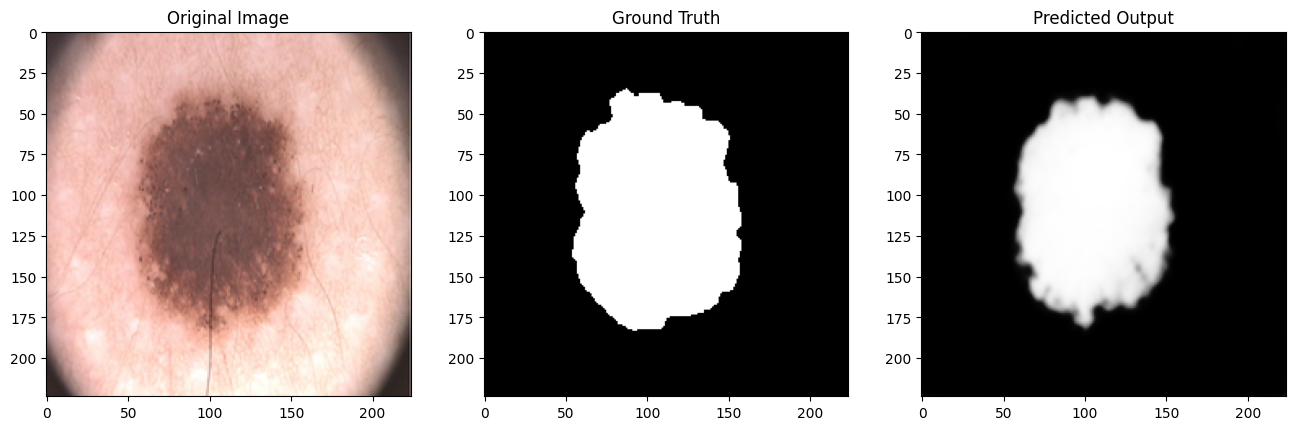

In [33]:
import numpy as np

img_num = 2
img_pred = model_1.predict(np.array([x_test[img_num]]).reshape(1,224,224,3))
plt.figure(figsize=(16,16))

# Scale the original image values to the range [0, 1]
orig_img = x_test[img_num] / 255.0 

plt.subplot(1,3,1)
plt.imshow(orig_img)
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')

plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')

plt.show()


1/1 [==============================] - 1s 552ms/step


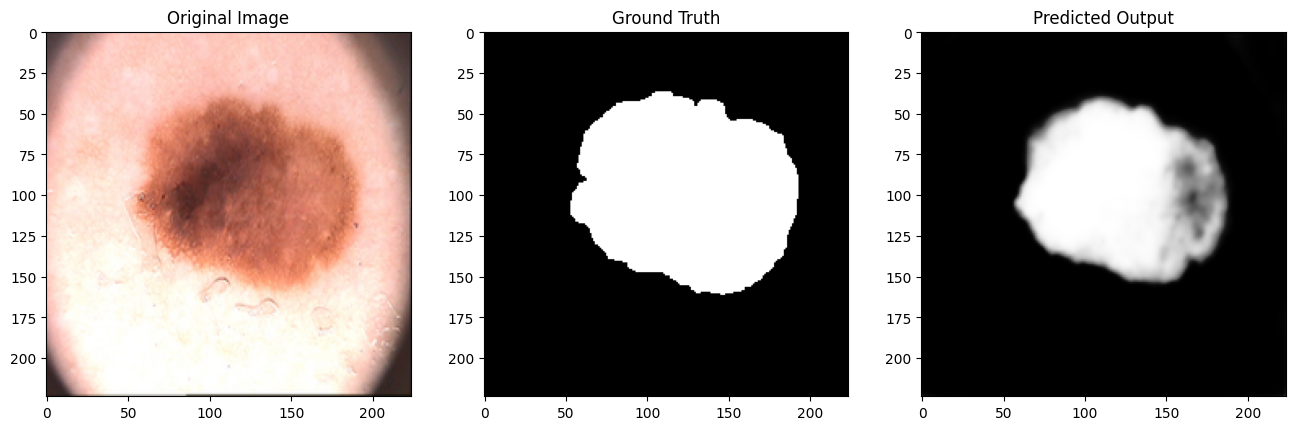

In [34]:
import numpy as np

img_num = 21
img_pred = model_1.predict(np.array([x_test[img_num]]).reshape(1,224,224,3))
plt.figure(figsize=(16,16))

# Scale the original image values to the range [0, 1]
orig_img = x_test[img_num] / 255.0 

plt.subplot(1,3,1)
plt.imshow(orig_img)
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')

plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')

plt.show()


In [35]:
def enhance(img):
    sub = model_1.predict(img.reshape(1, 224, 224, 3))
    sub = np.where(sub > 0.5, 1, 0)
    return sub.reshape(224, 224)

1/1 [==============================] - 1s 535ms/step


Text(0.5, 1.0, 'Predicted')

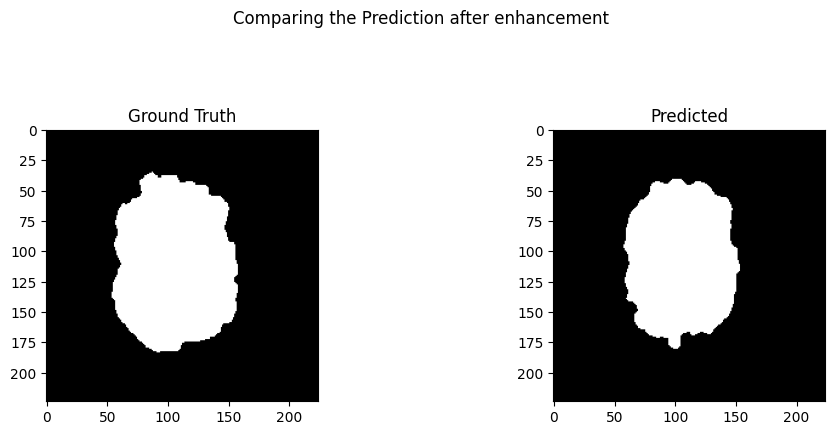

In [36]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[2],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(np.array(enhance(x_test[2].numpy())).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')

1/1 [==============================] - 1s 518ms/step


Text(0.5, 1.0, 'Predicted')

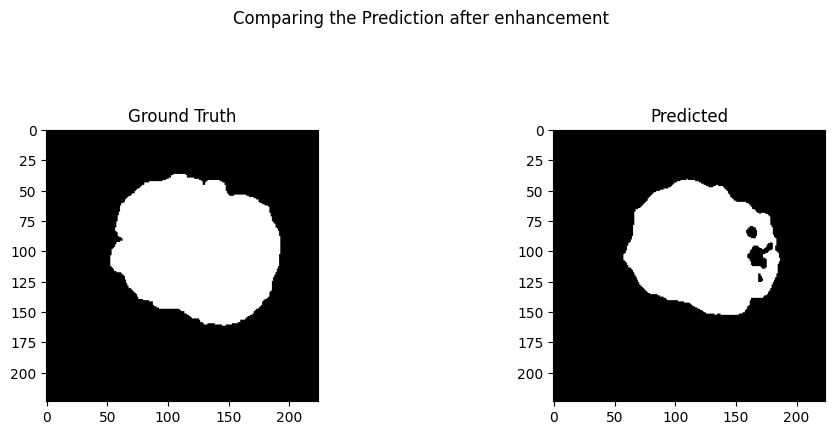

In [37]:
import numpy as np

plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(np.array(enhance(x_test[21].numpy())).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')


In [ ]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[23],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(np.array(enhance(x_test[23].numpy())).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')

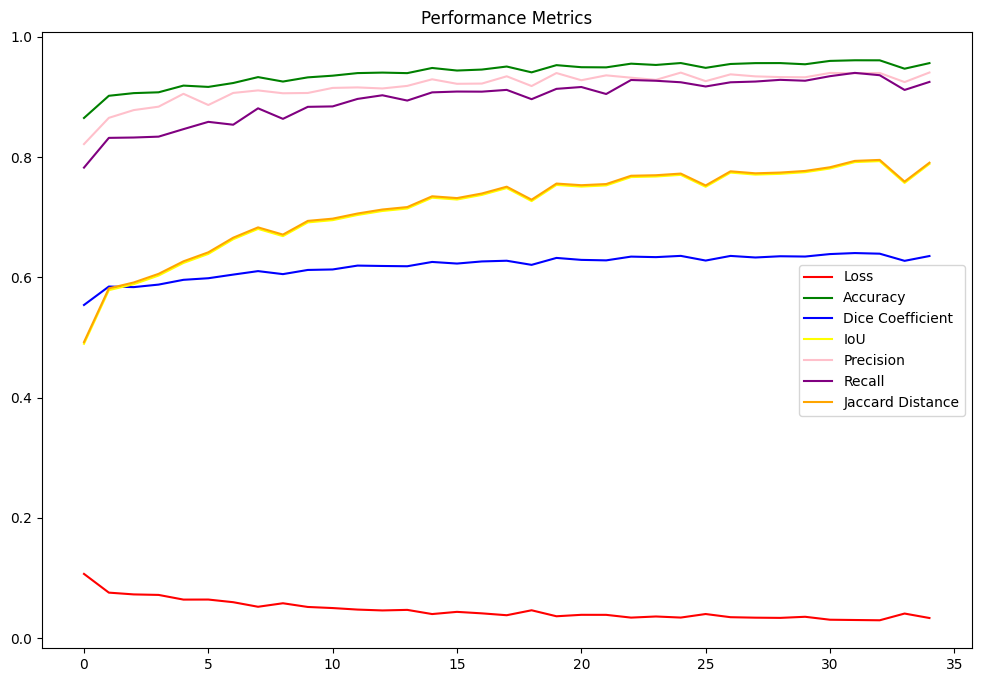

In [38]:
plt.figure(figsize=(12,8))
plt.gca()
plt.plot(hist.history['loss'], 'red')
plt.plot(hist.history['accuracy'], 'green')
plt.plot(hist.history['dice_coe'], 'blue')
plt.plot(hist.history['iou'], 'yellow')
plt.plot(hist.history['precision'], 'pink')
plt.plot(hist.history['recall'], 'purple')
plt.plot(hist.history['jaccard_distance'], 'orange')
plt.legend(['Loss', 'Accuracy','Dice Coefficient', 'IoU', 'Precision', 'Recall', 'Jaccard Distance'])
plt.title('Performance Metrics')
plt.show()

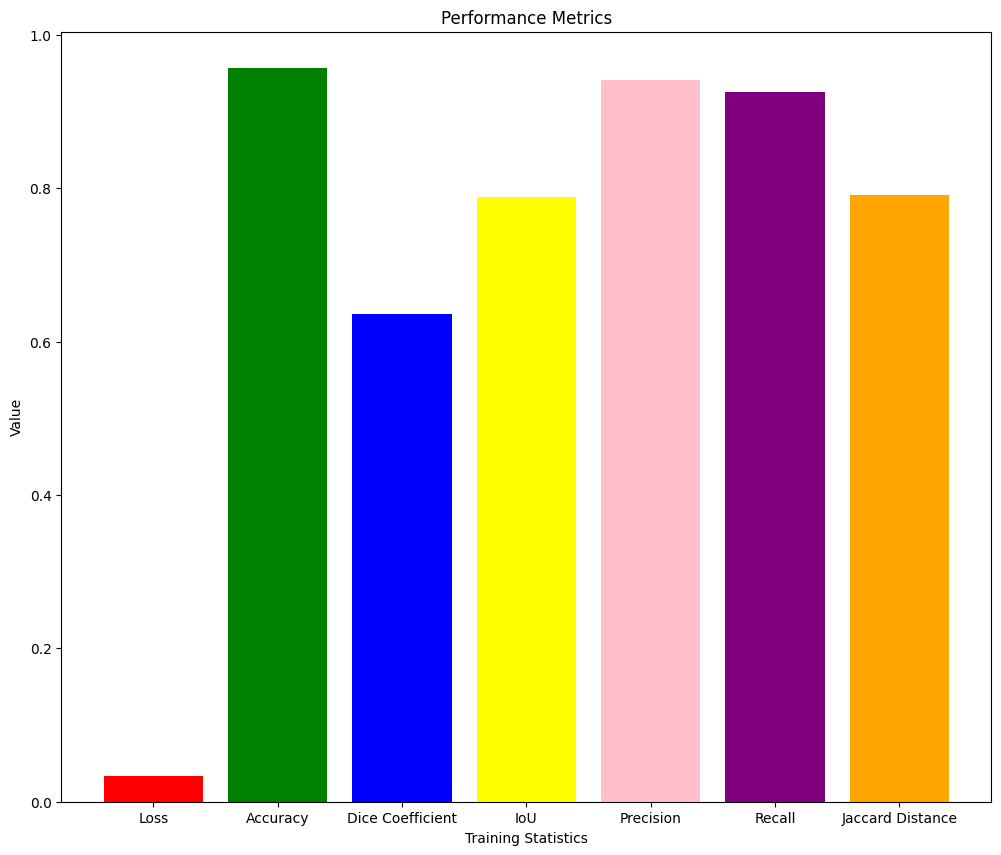

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Define the training statistics and their values
training_stats = ['Loss', 'Accuracy', 'Dice Coefficient', 'IoU', 'Precision', 'Recall', 'Jaccard Distance']
values = [hist.history['loss'][-1], hist.history['accuracy'][-1], hist.history['dice_coe'][-1], hist.history['iou'][-1], hist.history['precision'][-1], hist.history['recall'][-1], hist.history['jaccard_distance'][-1]]

# Define the colors for each bar
colors = ['red', 'green', 'blue', 'yellow', 'pink', 'purple', 'orange']

# Set up the vertical bar chart
fig, ax = plt.subplots(figsize=(12,10))
ax.bar(training_stats, values, color=colors)
ax.set_title('Performance Metrics')
ax.set_xlabel('Training Statistics')
ax.set_ylabel('Value')

# Display the chart
plt.show()
